In [1]:
import torch

from tqdm import tqdm
device = torch.device("cuda")

In [2]:
from torchvision.models import resnet50, ResNet50_Weights

# Using pretrained weights:
weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=weights).to(device)

model.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 512, bias=False),
    torch.nn.BatchNorm1d(512),
    torch.nn.Dropout(p=0.5),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 7),
).to(device)
model.fc.load_state_dict(torch.load("layers.pt"))

#model.conv1.requires_grad_(False)

print("Loaded updated model")

Loaded updated model


In [3]:
import torch

optimizer = torch.optim.AdamW(params=[p for p in model.parameters() if p.requires_grad], lr=1e-4)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.2)

criterion = torch.nn.CrossEntropyLoss()

losses = []
val_losses = []

sum(p.numel() for p in model.parameters())

24561223

In [4]:
import os
import pandas as pd
from torchvision.io import read_image
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms as T

class CountingDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path, ) / 255.0
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label
    
annotations_file = "../Apple/counting/train/train_ground_truth.txt"
img_dir = "../Apple/counting/train/images/"
transform = T.Compose([
    T.Resize((224,224), antialias=True),
    T.RandomHorizontalFlip(p=0.5),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_dataset = CountingDataset(annotations_file, img_dir, transform=transform)

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_annotations_file = "../Apple/counting/val/val_ground_truth.txt"
val_img_dir = "../Apple/counting/val/images/"
val_transform = T.Compose([
    T.Resize((224,224), antialias=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_dataset = CountingDataset(val_annotations_file, val_img_dir, transform=val_transform)

val_batch_size = 16
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)

In [5]:
num_epochs = 30

for epoch in (range(num_epochs)):
    prev_target = None
    model.train()
    for batch_input, batch_target in tqdm(train_dataloader):

        if batch_input.shape[0] < batch_size:
            continue

        optimizer.zero_grad()

        pred = model(batch_input.to(device))

        loss = criterion(pred, batch_target.to(device))

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        prev_target = batch_target

    model.eval()
    with torch.no_grad():
        val_num_examples = 0.0
        val_num_apples = 0
        for val_input, val_target in (val_dataloader):
            val_pred = model(val_input.to(device))
            val_error = torch.abs(val_target-val_pred.argmax(dim=1).cpu())
            val_num_apples += torch.sum(val_error).item()
            val_num_examples += torch.count_nonzero(val_error).item()
        val_losses.append((val_num_examples, val_num_apples))
        print((val_num_examples, val_num_apples))

    torch.save(model.state_dict(), f"model_states/epoch{epoch+1}.pt")
    lr_scheduler.step()

100%|██████████| 4038/4038 [05:54<00:00, 11.39it/s]


(534.0, 623)


100%|██████████| 4038/4038 [05:40<00:00, 11.85it/s]


(367.0, 402)


100%|██████████| 4038/4038 [05:36<00:00, 12.00it/s]


(269.0, 304)


100%|██████████| 4038/4038 [05:34<00:00, 12.05it/s]


(276.0, 314)


100%|██████████| 4038/4038 [05:24<00:00, 12.45it/s]


(196.0, 220)


100%|██████████| 4038/4038 [05:36<00:00, 12.01it/s]


(130.0, 143)


100%|██████████| 4038/4038 [05:35<00:00, 12.05it/s]


(123.0, 134)


100%|██████████| 4038/4038 [05:37<00:00, 11.97it/s]


(113.0, 123)


100%|██████████| 4038/4038 [05:40<00:00, 11.86it/s]


(116.0, 131)


100%|██████████| 4038/4038 [05:43<00:00, 11.75it/s]


(112.0, 125)


100%|██████████| 4038/4038 [05:43<00:00, 11.76it/s]


(110.0, 122)


100%|██████████| 4038/4038 [05:43<00:00, 11.77it/s]


(107.0, 121)


100%|██████████| 4038/4038 [05:36<00:00, 12.01it/s]


(104.0, 117)


100%|██████████| 4038/4038 [05:41<00:00, 11.84it/s]


(100.0, 111)


100%|██████████| 4038/4038 [05:37<00:00, 11.95it/s]


(98.0, 113)


100%|██████████| 4038/4038 [05:27<00:00, 12.35it/s]


(98.0, 110)


100%|██████████| 4038/4038 [05:35<00:00, 12.04it/s]


(101.0, 114)


100%|██████████| 4038/4038 [05:30<00:00, 12.23it/s]


(100.0, 113)


100%|██████████| 4038/4038 [05:30<00:00, 12.20it/s]


(99.0, 110)


100%|██████████| 4038/4038 [05:39<00:00, 11.89it/s]


(99.0, 113)


100%|██████████| 4038/4038 [05:32<00:00, 12.14it/s]


(105.0, 120)


 11%|█         | 454/4038 [00:38<05:02, 11.85it/s]


KeyboardInterrupt: 

In [6]:
from matplotlib import pyplot as plt
import numpy as np

0.006270135353647568


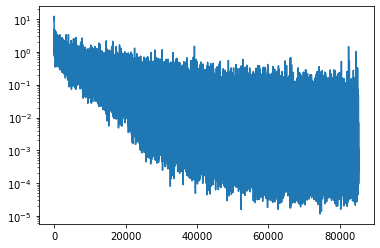

In [7]:
plt.semilogy(losses)
print(np.mean(losses[-len(train_dataset)//batch_size:]))

[(534.0, 623),
 (367.0, 402),
 (269.0, 304),
 (276.0, 314),
 (196.0, 220),
 (130.0, 143),
 (123.0, 134),
 (113.0, 123),
 (116.0, 131),
 (112.0, 125),
 (110.0, 122),
 (107.0, 121),
 (104.0, 117),
 (100.0, 111),
 (98.0, 113),
 (98.0, 110),
 (101.0, 114),
 (100.0, 113),
 (99.0, 110),
 (99.0, 113),
 (105.0, 120)]

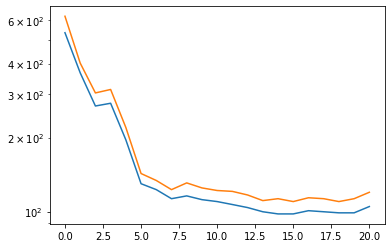

In [10]:
plt.plot([x[0] for x in val_losses])
plt.plot([x[1] for x in val_losses])
val_losses

[(534.0, 623),
 (367.0, 402),
 (269.0, 304),
 (276.0, 314),
 (196.0, 220),
 (130.0, 143),
 (123.0, 134),
 (113.0, 123),
 (116.0, 131),
 (112.0, 125),
 (110.0, 122),
 (107.0, 121),
 (104.0, 117),
 (100.0, 111),
 (98.0, 113),
 (98.0, 110),
 (101.0, 114),
 (100.0, 113),
 (99.0, 110),
 (99.0, 113),
 (105.0, 120)]

In [9]:
val_losses[-1][0] / len(val_dataset)

0.030927835051546393